# CSE475 PROJECT MURA DATASET

In [31]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [32]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
from concurrent.futures import ThreadPoolExecutor

In [33]:
DATASET_PATH = ".\\Dataset\\MURA-v1.1\\"  # Change this to your dataset path

### NO OF CLASSES

In [34]:
# Calculate and print the number of classes using the 'classes' list
train_path = os.path.join(DATASET_PATH, "train")
class_dirs = os.listdir(train_path)
num_classes = len(class_dirs)
print("There are", num_classes, "classes.")
print(class_dirs)


There are 7 classes.
['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


### Count images per class in the train directory

In [35]:
# Count images per class in the train directory
train_dir = os.path.join(DATASET_PATH, "train")
images_count = {}
for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    count_per_class = 0
    for root, dirs, files in os.walk(class_path):
        count_per_class += sum(1 for file in files if file.lower().endswith('.png'))
    images_count[class_name] = count_per_class
total_images = sum(images_count.values())
print("Total images in the train directory:", total_images)
print("Images count per class:")
for key, value in images_count.items():
    print(f"{key}: {value}")
    

Total images in the train directory: 68292
Images count per class:
XR_ELBOW: 9756
XR_FINGER: 9756
XR_FOREARM: 9756
XR_HAND: 9756
XR_HUMERUS: 9756
XR_SHOULDER: 9756
XR_WRIST: 9756


### SAMPLE IMG

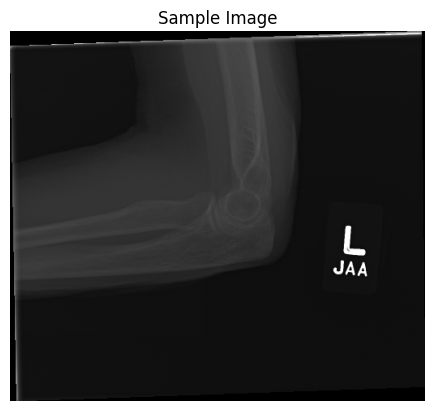

In [36]:
sample_img_path = 'Dataset\\MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png'
sample_img = Image.open(sample_img_path)
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.title('Sample Image')
plt.show()

### PLOT DISTRIBUTION

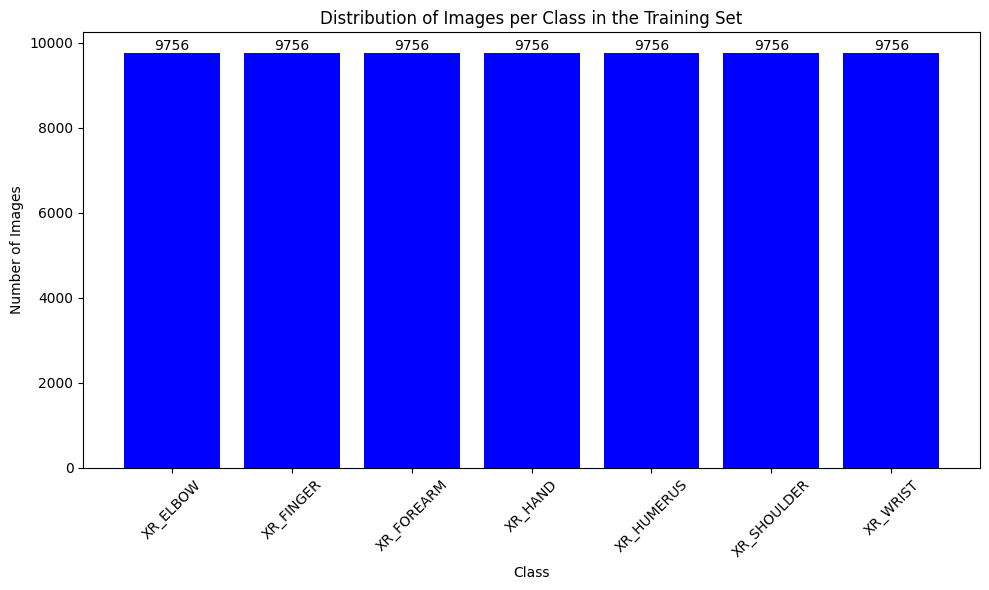

In [37]:
classes_list = list(images_count.keys())
counts_list = list(images_count.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes_list, counts_list, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in the Training Set')
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels at the top of each bar
for bar, count in zip(bars, counts_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()

In [38]:

def augment_image(image):
    """
    Apply a random augmentation to the given image.
    """
    aug_strategies = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(90),
        lambda img: img.rotate(180),
        lambda img: img.rotate(270)
    ]
    return random.choice(aug_strategies)(image)



In [39]:
# Determine the maximum number of images among all classes
max_images = max(images_count.values())
print("Max images in any class:", max_images)

Max images in any class: 9756


In [40]:
def process_augmentation(img_path, new_path):
    try:
        with Image.open(img_path) as img:
            augmented = augment_image(img)
            augmented.save(new_path)
    except Exception as e:
        print(f"Failed to augment {img_path}: {e}")

print("Augmenting dataset to balance all classes in parallel...")
tasks = []
with ThreadPoolExecutor() as executor:
    for class_name in class_dirs:
        class_path = os.path.join(train_dir, class_name)
        # Recursively get list of image files in the class directory.
        img_files = []
        for root, dirs, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith('.png'):
                    img_files.append(os.path.join(root, file))
        current_count = len(img_files)
        needed = max_images - current_count

        if needed > 0:
            if not img_files:
                print(f"No images found in {class_path}. Skipping augmentation for this class.")
                continue
            print(f"Class '{class_name}' has {current_count} images. Augmenting with {needed} additional image(s).")
            for i in range(needed):
                # Randomly select an image to augment.
                img_file = random.choice(img_files)
                new_filename = f"aug_{i}_{os.path.basename(img_file)}"
                # Save the new image in the same directory as the original.
                new_path = os.path.join(os.path.dirname(img_file), new_filename)
                tasks.append(executor.submit(process_augmentation, img_file, new_path))
        else:
            print(f"Class '{class_name}' is already balanced.")

# Wait for all augmentations to finish.
for task in tasks:
    task.result()

Augmenting dataset to balance all classes in parallel...
Class 'XR_ELBOW' is already balanced.
Class 'XR_ELBOW' is already balanced.
Class 'XR_FINGER' is already balanced.
Class 'XR_FINGER' is already balanced.
Class 'XR_FOREARM' is already balanced.
Class 'XR_FOREARM' is already balanced.
Class 'XR_HAND' is already balanced.
Class 'XR_HUMERUS' is already balanced.
Class 'XR_HAND' is already balanced.
Class 'XR_HUMERUS' is already balanced.
Class 'XR_SHOULDER' is already balanced.
Class 'XR_WRIST' is already balanced.
Class 'XR_SHOULDER' is already balanced.
Class 'XR_WRIST' is already balanced.


In [41]:
# Recalculate and show the distribution of images after augmentation
new_images_count = {}
for cdir in class_dirs:
    cpath = os.path.join(train_dir, cdir)
    cnt = 0
    for r, d, f in os.walk(cpath):
        cnt += sum(1 for x in f if x.lower().endswith('.png'))
    new_images_count[cdir] = cnt

new_total = sum(new_images_count.values())
print("Total images in the train directory after augmentation:", new_total)
print("Images count per class after augmentation:")
for k, v in new_images_count.items():
    print(f"{k}: {v}")

Total images in the train directory after augmentation: 68292
Images count per class after augmentation:
XR_ELBOW: 9756
XR_FINGER: 9756
XR_FOREARM: 9756
XR_HAND: 9756
XR_HUMERUS: 9756
XR_SHOULDER: 9756
XR_WRIST: 9756


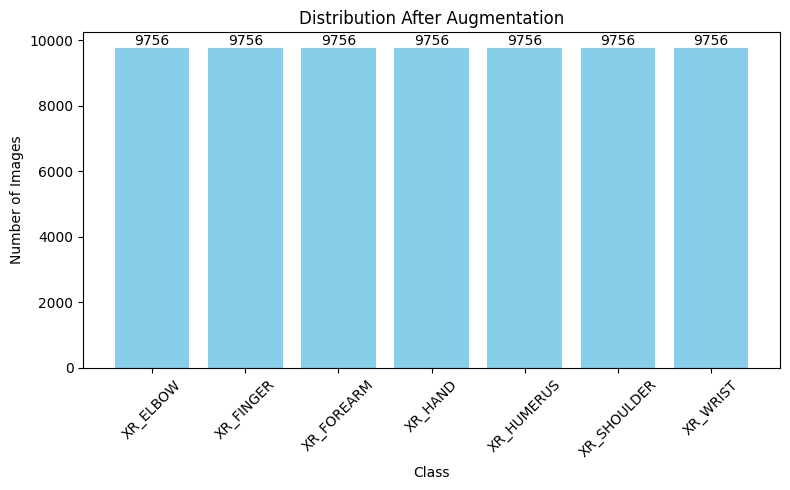

In [42]:
labels = list(new_images_count.keys())
values = list(new_images_count.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution After Augmentation')
plt.xticks(rotation=45)

for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(val),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [43]:
import torch
import torchvision
from torchvision import datasets

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Use the existing train_dir and num_classes variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Prepare Dataset and DataLoader for SimCLR

In [44]:
# Define standard transformations for loading images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset using ImageFolder
# Note: The augmentation transforms will be applied in the training loop
train_dataset = ImageFolder(root=train_dir, transform=transform)
print(f"Dataset created with {len(train_dataset)} images")

# Create the DataLoader
batch_size = 64  # Adjust based on your GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,  # Adjust based on your CPU cores
    pin_memory=True  # Speeds up data transfer to GPU
)

print(f"DataLoader created with {len(train_loader)} batches")

Dataset created with 68292 images
DataLoader created with 1068 batches


In [45]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define SimCLR model architecture and components
import torch.nn.functional as F

# Define the transformations for SimCLR (two different augmented views of the same image)
class SimCLRTransform:
    def __init__(self, size=224):
        self.train_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

# SimCLR model with ResNet backbone and projection head
class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', proj_dim=128):
        super(SimCLR, self).__init__()
        
        # Load pre-trained ResNet model as base encoder
        if base_model == 'resnet18':
            self.backbone = torchvision.models.resnet18(pretrained=True)
            feature_dim = 512
        elif base_model == 'resnet50':
            self.backbone = torchvision.models.resnet50(pretrained=True)
            feature_dim = 2048
        
        # Remove the final fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, proj_dim)
        )
        
    def forward(self, x):
        # Get feature representation from backbone
        x = self.backbone(x)
        # Flatten the features
        x = torch.flatten(x, start_dim=1)
        # Project features to lower dimension
        x = self.projection_head(x)
        # Normalize embeddings
        x = F.normalize(x, dim=1)
        return x

# NT-Xent (Normalized Temperature-scaled Cross Entropy) loss
def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.size(0)
    # Concatenate representations from both branches
    z = torch.cat([z1, z2], dim=0)
    # Compute similarity matrix
    sim = torch.mm(z, z.t()) / temperature
    # Mask out self-similarity
    sim_i_j = torch.diag(sim, batch_size)
    sim_j_i = torch.diag(sim, -batch_size)
    
    # Positive samples are pairs of augmentations of the same image
    positive_samples = torch.cat([sim_i_j, sim_j_i], dim=0).reshape(2 * batch_size, 1)
    # Negative samples are all other pairs
    mask = torch.ones_like(sim)
    mask = mask.fill_diagonal_(0)
    for i in range(batch_size):
        mask[i, batch_size + i] = 0
        mask[batch_size + i, i] = 0
    negative_samples = sim[mask.bool()].reshape(2 * batch_size, -1)
    
    # Compute loss
    logits = torch.cat([positive_samples, negative_samples], dim=1)
    labels = torch.zeros(2 * batch_size).to(device).long()  # Positive pair is at index 0
    loss = F.cross_entropy(logits, labels)
    
    return loss

# Initialize the SimCLR model
model = SimCLR(base_model='resnet18', proj_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-6)

print(f"SimCLR model initialized on {device}")
print(f"Model will be trained on {num_classes} classes from MURA dataset")

SimCLR model initialized on cuda
Model will be trained on 7 classes from MURA dataset


In [48]:
# Fix the training code to work with the dataset
import torchvision.transforms.functional as TF

num_epochs = 10  # adjust epochs as needed
batch_transforms = SimCLRTransform()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:  # Ignore labels
        images = images.to(device)
        
        # Convert tensors to PIL images first
        xi = torch.stack([batch_transforms.train_transform(TF.to_pil_image(img.cpu())) for img in images])
        xj = torch.stack([batch_transforms.train_transform(TF.to_pil_image(img.cpu())) for img in images])
        
        # Move augmented images back to device
        xi = xi.to(device)
        xj = xj.to(device)
        
        # Forward pass
        zi = model(xi)
        zj = model(xj)
        
        # Compute loss
        loss = nt_xent_loss(zi, zj)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "e:\CSE475\.venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "e:\CSE475\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "e:\CSE475\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 245, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "e:\CSE475\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 284, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "e:\CSE475\.venv\Lib\site-packages\torchvision\datasets\folder.py", line 263, in pil_loader
    img = Image.open(f)
          ^^^^^^^^^^^^^
  File "e:\CSE475\.venv\Lib\site-packages\PIL\Image.py", line 3532, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='.\\Dataset\\MURA-v1.1\\train\\XR_WRIST\\patient07840\\study1_negative\\._image1.png'>


### TODO NEXT MEETING
- find paper related to dataset and priority on ssl
- implement ssl simclr